# 策略梯度算法

本次作业包含2个代码填空和3个Exercise。

# 简介
之前我们介绍的Q-learning和DQN及改进算法都是基于价值（value-based）的方法，其中Q-learning是处理有限状态的算法，而DQN可以用来解决连续状态的问题。在强化学习中，除了基于值函数的方法，还有一支非常经典的方法，那就是基于策略（policy-based）的方法。对比两者，基于值函数的方法主要是学习值函数，然后根据值函数导出一个策略，此时并不存在一个显式的策略；而基于策略的方法则是直接显式的学习一个目标策略。策略梯度是基于策略的方法的基础，我们将从策略梯度算法说起。
# 策略梯度
基于策略的方法首先需要参数化策略，我们假设目标策略$\pi_\theta$是一个随机性策略，并且处处可微，其中$\theta$是对应的参数。我们的目标是要寻找一个最优策略，来最大化这个策略在环境中的期望回报。我们将策略学习的目标函数定义为
$$
J(\theta)= \mathbb{E}_{s_0}\left[V^{\pi_\theta}(s_0)\right]
$$
其中$s_0$表示初始状态。现在有了目标函数，我们将目标函数对策略$\theta$求导，得到导数后，我们就可以用梯度上升方法来最大化这个目标函数从而得到最优策略。

我们之前在MDP章节中学习过在策略$\pi$下的状态访问分布，我们在此用$\nu^{\pi}$表示。然后我们对目标函数求梯度，可以得到如下式子，更详细的推导将在扩展阅读中给出。

$$
\begin{align}
\nabla_{\theta}J(\theta)
&\propto \sum_{s \in S}\nu^{\pi_{\theta}}(s)\sum_{a \in A}Q^{\pi_{\theta}}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)\\
&=\sum_{s \in S}\nu^{\pi_{\theta}}(s)\sum_{a \in A}\pi_{\theta}(a|s)Q^{\pi_{\theta}}(s,a)\frac{\nabla_{\theta}\pi_{\theta}(a|s)}{\pi_{\theta}(a|s)}\\
&= \mathbb{E}_{\pi_{\theta}}[Q^{\pi_{\theta}}(s,a)\nabla_{\theta}\log \pi_{\theta}(a|s)]
\end{align}
$$
于是，我们就可以用这个梯度来更新策略。需要注意的是，因为上式期望$\mathbb{E}$的下标是$\pi_{\theta}$，所以策略梯度算法为在线策略（on-policy）算法，即必须使用当前策略$\pi_\theta$采样得到的数据来计算梯度。更一般地，我们可以把梯度写成下面这个形式：
$$
g = \mathbb{E}_{\pi_{\theta}}[\sum^{\infty}_{t=0}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})]
$$
其中$\psi_{t}$可以有很多种形式：
$$
\begin{align}
&1.\psi_{t}=\sum_{t=0}^{\infty}\gamma^t r_{t} : 轨迹的总回报  &&4.Q^{\pi_{\theta}}(s_{t},a_{t}) : 动作价值函数\\
&2.\psi_{t}=\sum_{t'=t}^{\infty} \gamma^{t'-t} r_{t'} : 动作 a_{t}之后的回报 &&5.A^{\pi_{\theta}}(s_{t},a_{t}): 优势函数\\
&3.\psi_{t}=\sum_{t'=t}^{\infty}r_{t'}-b(s_{t}) : 基准线版本的改进 \quad\quad \quad\quad &&6.r_{t} + V^{\pi_{\theta}}(s_{t+1}) - V^{\pi_{\theta}}(s_t) : 时序差分残差
\end{align}
$$
在计算策略梯度的公式中，我们需要用到$Q^{\pi_{\theta}}(s,a)$，可以用多种方式对它进行估计。接下来要介绍的 REINFORCE 算法便是采用了蒙特卡洛方法来估计$Q^{\pi_{\theta}}(s,a)$。

**Exercise 1.** 请简单阐述策略梯度方法与基于值函数的方法有何区别。

- 方式上：前者直接对策略进行参数化， 目标是优化策略性能的目标函数；后者评估状态价值函数，利用贝尔曼方程进行更新，然后根据这些价值函数构造策略。

- 策略表示上：前者有明确表示的策略，直接定义为带参数的概率分布；后者策略通常是隐式的，通过对值函数求最大值而获得。


# REINFORCE 算法
REINFORCE就是在上文中当$\psi_t=\sum_{t'=t}^{\infty}\gamma^{t'-t}r_{t'}$时的策略梯度算法。
具体流程如下：
$$
\begin{align}
&\cdot 初始化策略参数\theta \\
&\cdot \texttt{for}\quad 序列\quad e=1\to E\quad \texttt{do}: \\
&\cdot\qquad 用当前策略\pi_\theta采样轨迹\{s_{1},a_{1},r_{1},s_{2},a_{2},r_{2} ... s_{t},a_{t},r_{t}\}\\
&\cdot\qquad 计算当前轨迹每个时刻t往后的回报\sum_{t'=t}^{\infty}\gamma^{t'-t}r_{t'}，记为\psi_{t}\\
&\cdot\qquad 对\theta进行更新 \theta = \theta + \alpha \sum_{t=0}^{\infty}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})\\
&\cdot\texttt{end for}
\end{align}
$$

In [1]:
%pip install -i https://mirrors.sjtug.sjtu.edu.cn/pypi/web/simple gym
%pip install torch # No need to install cuda toolkit!

Looking in indexes: https://mirrors.sjtug.sjtu.edu.cn/pypi/web/simple
     ---------------------------------------- 0.0/721.7 kB ? eta -:--:--
     ------------------------------------- 721.7/721.7 kB 44.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827739 sha256=92a57506c92d753e8e99598b17966d32363a65929673d639dc850b8ca5e06908
  Stored in directory: c:\users\xun_y\appdata\local\pip\cache\wheels\b5\55\45\5738ce4eeea7e23b0ee6318d7bf853e2877a017f09f36b624d
Successfully built gym
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: '#'


In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.distributions import Categorical

eps = np.finfo(np.float32).eps.item()

定义我们的策略网络PolicyNet，输入是状态state，输出则是采取动作action的概率值（离散动作空间）

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, hidden_dim, state_space, action_space):
        super(PolicyNet, self).__init__()
        input_dim = state_space.shape[0]
        output_dim = action_space.n
        
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return  F.softmax(self.fc2(x), dim=1)

再定义我们的REINFORCE的Agent。在函数action()中，我们通过概率对离散的动作进行采样。在更新Agent的过程中，我们按照算法，将损失函数写为$-\sum_{t}\psi_{t}\nabla_{\theta}\log \pi_{\theta}(a_{t}|s_{t})$，对$\theta$求导就可以更新策略。

In [32]:
class Reinforce:
    def __init__(
        self, 
        hidden_size, state_space, action_space, 
        learning_rate, device, step_size, lr_gamma
    ):
        self.action_space = action_space
        self.model = PolicyNet(hidden_size, state_space, action_space).to(device)
        self.device = device
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        # learning rate调节
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size, lr_gamma)

    def action(self, state):
        ########################################
        ## Programming 1: 计算正确的action以及log_prob
        ########################################
        probs = self.model(state)  # 通过策略网络得到动作概率分布 [batch_size, action_dim]
        m = Categorical(probs)     # 创建分类分布
        action = m.sample()        # 采样动作 [batch_size]
        log_prob = m.log_prob(action)  # 计算对数概率 [batch_size]
        ########################################
        ## End of Programming 1
        ########################################
        return action, log_prob

    def update(self, rewards, log_probs, gamma):
        ########################################
        ## Programming 2: 更新策略网络
        ## REINFORCE算法通常不太稳定，如果得到的结果不理想可以尝试：
        ## 1. 对**Return**做标准化
        ## 2. 使用learning rate调节器
        ########################################
        returns = []
        R = 0
        for r in reversed(rewards): 
            R = r + gamma * R
            returns.insert(0, R) 
    
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)

        log_probs = torch.stack(log_probs) 

        loss = -torch.sum(log_probs * returns) 

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step() 
        ########################################
        ## End of Programming 2
        ########################################

定义好策略，我们就可以开始实验了，看看Reinforce在Cartpole环境上表现如何吧！

预计运行时间：2分钟

In [33]:
# 以下参数在助教实现的版本中能达到期望效果，可以多试几组参数
learning_rate = 1e-3
num_episode = 2000
hidden_size = 128
max_timesteps = 2000
env_name = "CartPole-v1"
gamma = 0.98
lr_gamma = 0.9
step_size = 500
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env = gym.make(env_name)
agent = Reinforce(
    hidden_size, 
    env.observation_space, 
    env.action_space, 
    learning_rate, 
    device,
    step_size,
    lr_gamma
)
rewards_log = []
episodes_log = []
for i_episode in range(num_episode):
    state = torch.tensor(np.array([env.reset()[0]]), device=device)
    log_probs = []
    rewards = []
    for time_step in range(max_timesteps):
        action, log_prob = agent.action(state)
        action = action.cpu()
        next_state, reward, terminated, truncated, _ = env.step(action.numpy()[0])
        done = terminated or truncated
        log_probs.append(log_prob)
        rewards.append(reward)
        # state = torch.Tensor([next_state], device=device)
        state = torch.tensor(next_state, dtype=torch.float32, device=device).unsqueeze(0)
        if done:
            break
    rewards_log.append(np.sum(rewards))
    episodes_log.append(i_episode)
    agent.update(rewards, log_probs, gamma)
    if (i_episode + 1) % 100 == 0 or i_episode + 1 == num_episode:
        print("Episode: {}, Reward: {}".format(i_episode+1, np.mean(rewards_log[-10:])))
env.close()

Episode: 100, Reward: 48.3
Episode: 200, Reward: 64.1
Episode: 300, Reward: 157.7
Episode: 400, Reward: 152.4
Episode: 500, Reward: 175.3
Episode: 600, Reward: 187.9
Episode: 700, Reward: 232.4
Episode: 800, Reward: 208.4
Episode: 900, Reward: 225.8
Episode: 1000, Reward: 163.3
Episode: 1100, Reward: 329.6
Episode: 1200, Reward: 331.5
Episode: 1300, Reward: 190.0
Episode: 1400, Reward: 286.9
Episode: 1500, Reward: 427.0
Episode: 1600, Reward: 455.4
Episode: 1700, Reward: 413.4
Episode: 1800, Reward: 457.0
Episode: 1900, Reward: 449.1
Episode: 2000, Reward: 386.1


在CartPole-v1环境中，满分就是500分，让我们来看看每个Episode得分如何吧！

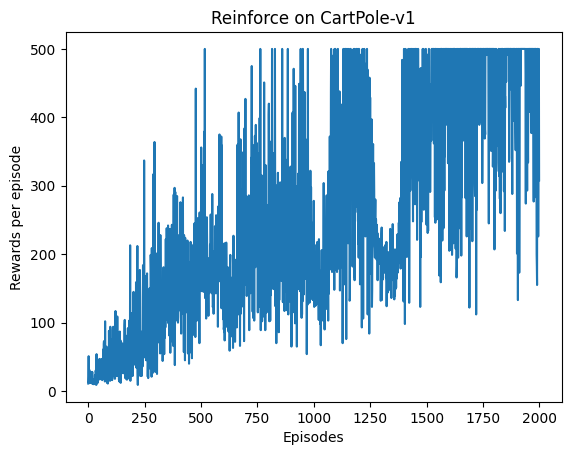

In [34]:
plt.plot(episodes_log,rewards_log)
plt.xlabel('Episodes')   
plt.ylabel('Rewards per episode')  
plt.title('Reinforce on {}'.format(env_name))  
plt.show()

参考训练曲线如下（最后能比较稳定保持在500即可）：

![Image Name](images/result.png)


**Exercise 2.** 在填写代码并训练的过程，你认为REINFORCE算法存在哪些问题？

- 没有baseline控制，训练过程波动很大，而且训练慢

- 难收敛

# 总结
REINFORCE算法理论上是能保证局部最优的。依赖于MC方法进行采样，优点是REINFORCE的采样梯度是无偏的。但是同样由于MC，导致REINFORCE梯度估计的方差很大，从而可能会降低学习的速率，这也是接下来的Actor-Critic算法要解决的问题。

# 拓展阅读：策略梯度证明
我们要证明$\nabla_{\theta}J(\theta) \propto \sum_{s \in S}\nu^{\pi_\theta}(s)\sum_{a \in A}Q^{\pi_\theta}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)$
                        
先从状态价值函数的推导开始：
$$
\begin{align}
\nabla_{\theta}V^{\pi_\theta}(s) &=\nabla_{\theta}(\sum_{a \in A} \pi_{\theta}(a|s)Q^{\pi_\theta}(s,a)) \\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \pi_{\theta}(a|s)\nabla_{\theta}Q^{\pi_\theta}(s,a))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \pi_{\theta}(a|s)\nabla_{\theta}\sum_{s',r}P(s',r|s,a)(r+\gamma V^{\pi_\theta}(s'))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \gamma\pi_{\theta}(a|s)\sum_{s',r}P(s',r|s,a)\nabla_{\theta}V^{\pi_\theta}(s'))\\
&=\sum_{a\in A}(\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a) + \gamma\pi_{\theta}(a|s)\sum_{s'}P(s'|s,a)\nabla_{\theta}V^{\pi_\theta}(s'))\\
\end{align}
$$
为了简化表示，我们让$\phi(s)=\sum_{a \in A}\nabla_{\theta}\pi_{\theta}(a|s)Q^{\pi_\theta}(s,a)$, 定义$\rho^{\pi}(s\rightarrow x, k)$为策略$\pi$从状态s出发k步后到达状态x的概率，我们继续推导:
$$
\begin{align}
\nabla_{\theta}V^{\pi_\theta}(s) &= \phi(s) + \gamma\sum_{a}\pi_{\theta}(a|s)\sum_{s'}P(s'|s,a)\nabla_{\theta}V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma\sum_{a}\sum_{s'}\pi_{\theta}(a|s)P(s'|s,a)\nabla_{\theta}V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)\nabla_{\theta}V^{\pi_\theta}(s')\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)[\phi(s') + \sum_{s''}\rho^{\pi_\theta}(s' \rightarrow s'',1)\nabla_{\theta}V^{\pi_\theta}(s'')]\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)\phi(s') + \sum_{s''}\rho^{\pi_\theta}(s \rightarrow s'',2)\nabla_{\theta}V^{\pi_\theta}(s'')\\
&= \phi(s) + \gamma\sum_{s'}\rho^{\pi_\theta}(s \rightarrow s',1)\phi(s') +\gamma^2\sum_{s''}\rho^{\pi_\theta}(s' \rightarrow s'',2)\phi(s'') + \gamma^3\sum_{s'''}\rho^{\pi_\theta}(s \rightarrow s''',3)\nabla_{\theta}V^{\pi_\theta}(s''')\\
&= ......\\
&= \sum_{x \in S}\sum^{\infty}_{k=0}\gamma^k\rho^{\pi_\theta}(s \rightarrow x, k)\phi(x)
\end{align}
$$
OK! 我们定义$\eta(s)= \mathbb{E}_{s_0}\left[\sum^{\infty}_{k=0}\gamma^k\rho^{\pi}(s_{0} \rightarrow s, k)\right]$。
至此我们看回我们的目标函数：
$$
\begin{align}
\nabla_{\theta}J(\theta) &= \nabla_{\theta}\mathbb{E}_{s_0}\left[V^{\pi_\theta}(s_{0})\right]\\
&= \sum_{s}\mathbb{E}_{s_0}\left[\sum^{\infty}_{k=0}\gamma^k\rho^{\pi_\theta}(s_{0} \rightarrow s, k)\right]\phi(s)\\
&= \sum_{s}\eta(s)\phi(s)\\
&= \left(\sum_{s}\eta(s)\right)\sum_{s}\frac{\eta(s)}{\sum_{s}\eta(s)}\phi(s)\\
&\propto \sum_{s}\frac{\eta(s)}{\sum_{s}\eta(s)}\phi(s)\\
&= \sum_{s}\nu^{\pi_\theta}(s)\sum_{a}Q^{\pi_\theta}(s,a)\nabla_{\theta}\pi_{\theta}(a|s)
\end{align}
$$
证明完毕！

**Exercise 3.** 以优势函数$A(s_t,a_t)$为例，请说明为什么沿着梯度$g$的方向优化就可以学到一个收益更大的策略。

优势函数$A(s_t,a_t)$衡量的是在某个状态$s_t$下采取动作$a_t$相对于该状态下平均行为的好坏程度。

在策略梯度方法中，梯度通常写为：$g=\mathbb{E}\left[\nabla_{\theta} \log \pi_{\theta}\left(a_{t} \mid s_{t}\right) A\left(s_{t}, a_{t}\right)\right]$

因此， 当$A(s_t,a_t)>0$时，梯度的方向会推动增加该动作在给定状态下的概率。

因此，当我们沿着梯度$g$的方向优化策略参数时，就会倾向于使得在各个状态下，更优（优势为正）的动作的概率得到提升，而较差动作（优势为负）的概率减小。这样，经过更新后的策略会在相同状态下更多选择那些能够获得超出平均回报的动作，从而整体提升策略的期望收益。
